This notebook serves as a supplement to the paper. The paper contains all the details, and this notebook is primarily used to generate the plots featured in the paper. I will briefly discuss each step here, but the explanations will not be as detailed as in the paper. Most of the code is taken from `moonOrbit.py`, with only a few plotting functions defined here.

Let's start by importing some necessary modules:

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from moonOrbit import (
    build_time_varying_lqr_controller,
    get_control_K,
    getControlPMP_for_t,
    reference_state,
    simulate_orbit,
    solvePMP,
)

Next, let's set a seed for the random number generator to ensure consistent results between runs. The only randomness comes from the perturbations:

In [2]:
np.random.seed(42)

Here, I define a function that draws the path using arrows to visualize how the spaceship moves over time:

In [3]:
def arrowPlot(ax, n_arrows, x, y, arrowHeadSize=0.05):
    indices = np.linspace(0, len(x) - 2, n_arrows).astype(int)[1:]
    for i in indices:
        dx = x[i + 1] - x[i]
        dy = y[i + 1] - y[i]
        ax.arrow(
            x[i],
            y[i],
            dx,
            dy,
            shape="full",
            lw=0,
            length_includes_head=True,
            head_width=arrowHeadSize,
            color="black",
            alpha=1.0,
        )
    return ax

Let's see the simulation where we simply try to stay in orbit:

In [4]:
GM = 1.0  # gravitational parameter
r0 = 1  # Start orbit
w0 = np.sqrt(GM / (r0**3))

# time to simulate
T = 6.3
dt = 0.01

# start values
x0 = np.array([r0, 0, 0, w0])
t, x, u, r_arr, theta_arr, v_r_arr, v_t_arr = simulate_orbit(r0, GM, x0, dt=dt, T=T)

x_pos_old = r_arr * np.cos(theta_arr)
y_pos_old = r_arr * np.sin(theta_arr)

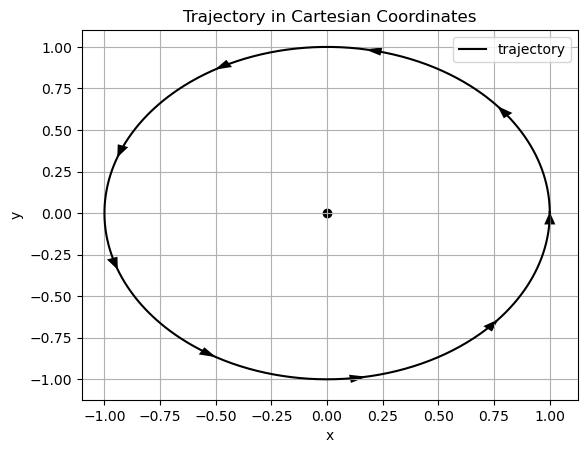

In [5]:
# plot
fig, ax = plt.subplots()
ax.plot(x_pos_old, y_pos_old, label="trajectory", color="black")
ax.scatter([0], [0], color="black")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Trajectory in Cartesian Coordinates")
ax.grid(True)
ax.legend(loc=1)
ax = arrowPlot(ax, 10, x_pos_old, y_pos_old)
plt.savefig("../Documentation/Plots/StableOrbit")
plt.show()

We can see that the RK4 method is stable, allowing the spaceship to remain in orbit if the initial speed is correct.

Now, let's see what happens if we add some perturbations:

In [6]:
T = 12
# perturbations:
s1, s2 = 0.005, 0.00
perturb = np.random.normal(loc=[0, 0], scale=[s1, s2], size=(int(T // dt) + 1, 2)).T

# simulate
t, x, u, r_arr, theta_arr, v_r_arr, v_t_arr = simulate_orbit(
    r0, GM, x0, dt=dt, T=T, perturb=perturb
)

x_pos = r_arr * np.cos(theta_arr)
y_pos = r_arr * np.sin(theta_arr)

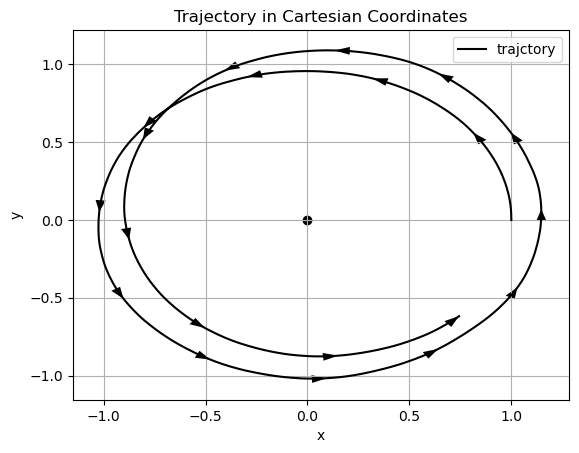

In [7]:
# plot
fig, ax = plt.subplots()
ax.plot(x_pos, y_pos, label="trajctory", color="black")
ax.scatter([0], [0], color="black")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Trajectory in Cartesian Coordinates")
ax.grid(True)
ax.legend(loc=1)
ax = arrowPlot(ax, 21, x_pos, y_pos)
plt.savefig("../Documentation/Plots/UnStablePerturbedOrbit")
plt.show()

We observe that with perturbations, the orbit quickly becomes unstable. This is where the HJB equation becomes useful:

In [8]:
# Get control:
K = get_control_K(GM, r0, w0)

# simulate
t, x, u, r_arr, theta_arr, v_r_arr, v_t_arr = simulate_orbit(
    r0, GM, x0, dt=dt, T=T, K=K, u_max=None, perturb=perturb
)

x_pos = r_arr * np.cos(theta_arr)
y_pos = r_arr * np.sin(theta_arr)

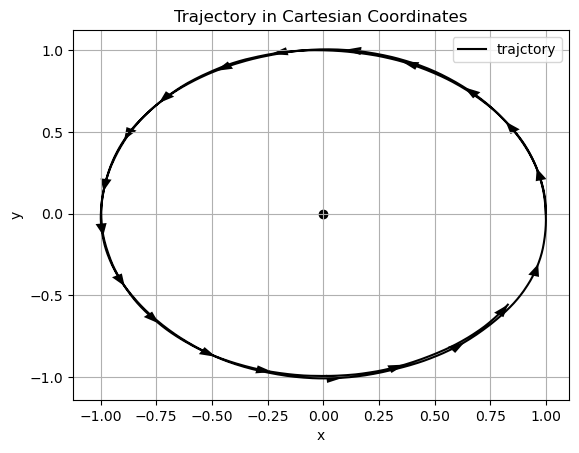

In [9]:
# plot
fig, ax = plt.subplots()
ax.plot(x_pos, y_pos, label="trajctory", color="black")
ax.scatter([0], [0], color="black")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Trajectory in Cartesian Coordinates")
ax.grid(True)
ax.legend(loc=1)
ax = arrowPlot(ax, 21, x_pos, y_pos)
plt.savefig("../Documentation/Plots/ControlledHJBPerturbedOrbit")
plt.show()

We can see that the controller keeps the orbit intact, which is great. The policy matrix K that achieves this produces the following vector field:

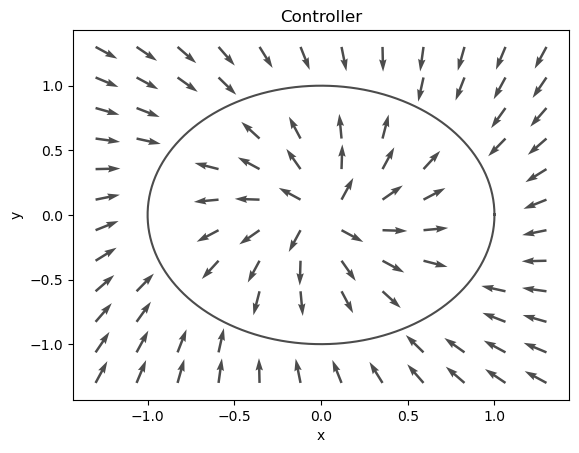

In [10]:
# Visualize K as a vector field in (x, y) by evaluating at [r, 0, w0] around the orbit
grid_points = 12
X = np.linspace(-1.3, 1.3, grid_points)
Y = np.linspace(-1.3, 1.3, grid_points)
X, Y = np.meshgrid(X, Y)

# Convert (X, Y) to polar coordinates (R, Theta)
R = np.sqrt(X**2 + Y**2)
Theta = np.arctan2(Y, X)

U = np.zeros_like(X)
V = np.zeros_like(Y)

min_norm = 0.1  # Threshold for minimum arrow length

for i in range(grid_points):
    for j in range(grid_points):
        r = R[i, j]
        if np.abs(r - r0) < 0.2:
            continue
        theta = Theta[i, j]
        state = np.array([r, 0, w0])
        ref = np.array([r0, 0, w0])
        u = -K @ (state - ref)
        u_x = u[0] * np.cos(theta) - u[1] * np.sin(theta)
        u_y = u[0] * np.sin(theta) + u[1] * np.cos(theta)
        norm = np.linalg.norm([u_x, u_y])
        if norm > min_norm:
            U[i, j] = u_x / norm
            V[i, j] = u_y / norm
        else:
            U[i, j] = 0
            V[i, j] = 0

fig, ax = plt.subplots()
mask = (U != 0) | (V != 0)
q = ax.quiver(
    X[mask],
    Y[mask],
    U[mask],
    V[mask],
    color="black",
    alpha=0.7,
    width=0.005,
    scale=20,
    label="K field",
)
ax.plot(
    x_pos_old, y_pos_old, label="trajctory", color="black", linestyle="-", alpha=0.7
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Controller")
plt.savefig("../Documentation/Plots/HJBPolicy")
plt.show()

This vector field give us a good idea about how the controller works.
Can we also use the controller to change the orbit?

In [11]:
# Get control:
r1 = 0.8
w1 = np.sqrt(GM / (r1**3))
K = get_control_K(GM, r1, w1)

# simulate
t, x, u, r_arr, theta_arr, v_r_arr, v_t_arr = simulate_orbit(
    r1, GM, x0, dt=dt, T=T, K=K, u_max=None
)
x_pos_new = r_arr * np.cos(theta_arr)
y_pos_new = r_arr * np.sin(theta_arr)

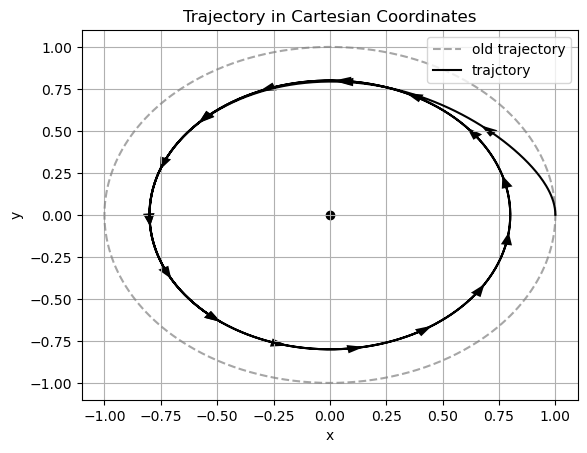

In [12]:
# plot
fig, ax = plt.subplots()
ax.plot(
    x_pos_old,
    y_pos_old,
    label="old trajectory",
    color="gray",
    linestyle="--",
    alpha=0.7,
)
ax.plot(x_pos_new, y_pos_new, label="trajctory", color="black")
ax.scatter([0], [0], color="black")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Trajectory in Cartesian Coordinates")
ax.grid(True)
ax.legend(loc=1)
ax = arrowPlot(ax, 21, x_pos_new, y_pos_new)
plt.savefig("../Documentation/Plots/SmallOrbitChangeHJB")
plt.show()

We can see that this approach works well for small changes in the orbit. But can it handle larger changes?

In [13]:
# Get control:
r1 = 0.35
w1 = np.sqrt(GM / (r1**3))
K = get_control_K(GM, r1, w1)

# simulate
t, x, u, r_arr, theta_arr, v_r_arr, v_t_arr = simulate_orbit(
    r1, GM, x0, dt=dt, T=T, K=K, u_max=None
)
x_pos_new = r_arr * np.cos(theta_arr)
y_pos_new = r_arr * np.sin(theta_arr)

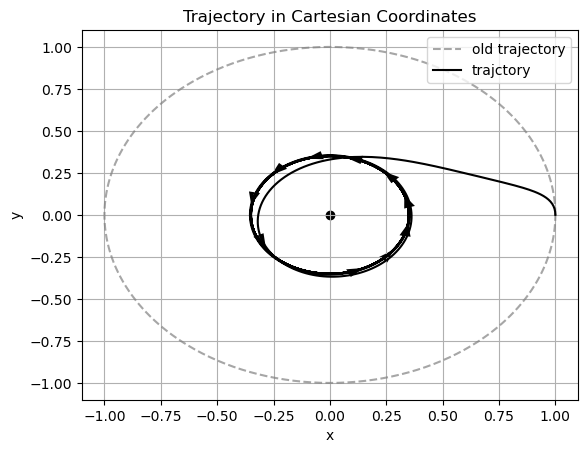

In [14]:
# plot
fig, ax = plt.subplots()
ax.plot(
    x_pos_old,
    y_pos_old,
    label="old trajectory",
    color="gray",
    linestyle="--",
    alpha=0.7,
)
ax.plot(x_pos_new, y_pos_new, label="trajctory", color="black")
ax.scatter([0], [0], color="black")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Trajectory in Cartesian Coordinates")
ax.grid(True)
ax.legend(loc=1)
ax = arrowPlot(ax, 11, x_pos_new, y_pos_new)
plt.savefig("../Documentation/Plots/LargeOrbitChangeHJB")
plt.show()

We see that the controller is much less effective when we try to change the radius of the orbit significantly. This is because the dynamics have been linearized, which works for small changes but not for large ones. The linearized dynamics deviate too much from the true nonlinear behavior.

There are other controllers that do not rely on linearization. One of these is PMP:

In [15]:
T = 22
sol = solvePMP(GM, T, r0, r1, 0, w0)

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          6.03e-02       2.78e-17          400            783      
       2          2.78e-05       3.04e-17         1183            885      
       3          8.59e-07       5.46e-17         2068             0       
Solved in 3 iterations, number of nodes 2068. 
Maximum relative residual: 8.59e-07 
Maximum boundary residual: 5.46e-17
solve_bvp success: True | message: The algorithm converged to the desired accuracy.


In [16]:
u_r, u_theta, _, _, _ = getControlPMP_for_t(sol, 0.1)

In [17]:
# simulate
t, x, u, r_arr, theta_arr, v_r_arr, v_t_arr = simulate_orbit(
    r1, GM, x0, dt=dt, T=T, K=None, u_max=None, usePMP=True, PMP_sol=sol
)
x_pos_new_non_perturbed = r_arr * np.cos(theta_arr)
y_pos_new_non_perturbed = r_arr * np.sin(theta_arr)

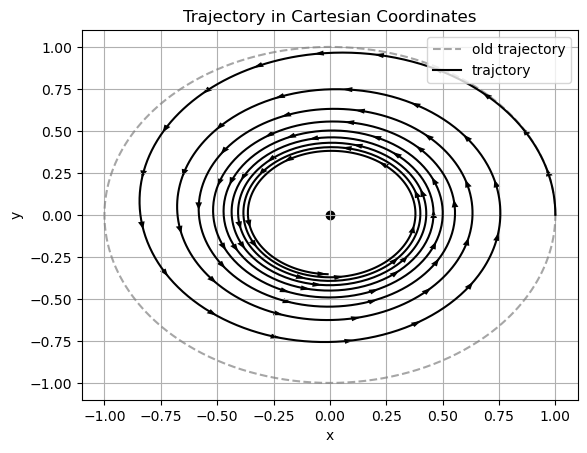

In [18]:
# plot
fig, ax = plt.subplots()
ax.plot(
    x_pos_old,
    y_pos_old,
    label="old trajectory",
    color="gray",
    linestyle="--",
    alpha=0.7,
)
ax.plot(
    x_pos_new_non_perturbed, y_pos_new_non_perturbed, label="trajctory", color="black"
)
ax.scatter([0], [0], color="black")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Trajectory in Cartesian Coordinates")
ax.grid(True)
ax.legend(loc=1)
ax = arrowPlot(
    ax, 81, x_pos_new_non_perturbed, y_pos_new_non_perturbed, arrowHeadSize=0.03
)
plt.savefig("../Documentation/Plots/OrbitChangePMP")
plt.show()

We see that the PMP method allows for a smooth transition to the desired orbit, which is impressive. 

Can it also handle perturbations?

In [19]:
# simulate
perturb = np.random.normal(loc=[0, 0], scale=[s1, s2], size=(int(T // dt) + 1, 2)).T
t, x, u, r_arr, theta_arr, v_r_arr, v_t_arr = simulate_orbit(
    r1,
    GM,
    x0,
    dt=dt,
    T=T,
    K=None,
    u_max=None,
    usePMP=True,
    PMP_sol=sol,
    perturb=perturb,
)
x_pos_new = r_arr * np.cos(theta_arr)
y_pos_new = r_arr * np.sin(theta_arr)

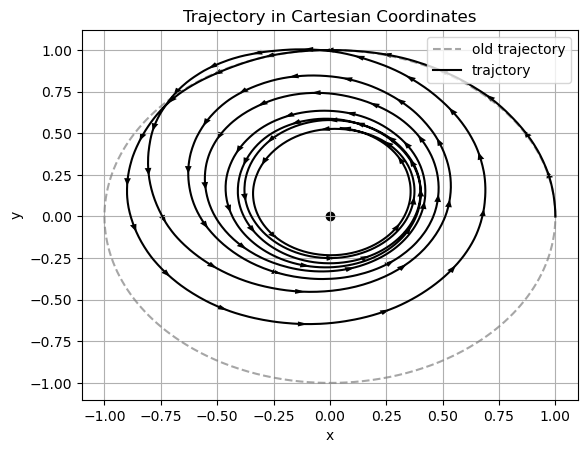

In [20]:
# plot
fig, ax = plt.subplots()
ax.plot(
    x_pos_old,
    y_pos_old,
    label="old trajectory",
    color="gray",
    linestyle="--",
    alpha=0.7,
)
ax.plot(x_pos_new, y_pos_new, label="trajctory", color="black")
ax.scatter([0], [0], color="black")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Trajectory in Cartesian Coordinates")
ax.grid(True)
ax.legend(loc=1)
ax = arrowPlot(ax, 81, x_pos_new, y_pos_new, arrowHeadSize=0.03)
plt.savefig("../Documentation/Plots/OrbitChangePerturbedPMP")
plt.show()

We observe that the transition does not go as smoothly when perturbations are present. The noise disrupts the planned trajectory. This happens because PMP is not a closed-loop method like HJB and therefore cannot handle feedback.

One way to address this is to combine PMP and HJB. PMP excels at planning, while HJB is effective at controlling the system along a nearby path. By having HJB track the position and velocity that PMP plans for each time step, we can recalculate HJB to match the desired trajectory from PMP.

In [21]:
def get_control_fn(t):
    u_r, u_theta, _, _, _ = getControlPMP_for_t(sol, t)
    return u_r, u_theta

In [22]:
R = np.diag([10.0, 10.0])
Q = np.zeros((3, 3))
S = np.diag([1.0, 0.0, 0.0])

N = 400
t_grid = np.linspace(0.0, T, N)

controller, K_of_t = build_time_varying_lqr_controller(
    ref_state_fn=lambda x: reference_state(x, sol),
    ref_control_fn=get_control_fn,
    t_grid=t_grid,
    R=R,
    Q=Q,
    S=S,
    mu=GM,
    thruster_limits=[1, 1],
)

In [23]:
# simulate
perturb = np.random.normal(
    loc=[0, 0], scale=[0.5 * s1, s2], size=(int(T // dt) + 1, 2)
).T
t, x, u, r_arr, theta_arr, v_r_arr, v_t_arr = simulate_orbit(
    r1,
    GM,
    x0,
    dt=dt,
    T=T,
    K=None,
    u_max=None,
    usePMP=True,
    PMP_sol=sol,
    perturb=perturb,
    combination=True,
    time_vary=True,
    controller=controller,
    overTake=1.2,
)
x_pos_new = r_arr * np.cos(theta_arr)
y_pos_new = r_arr * np.sin(theta_arr)

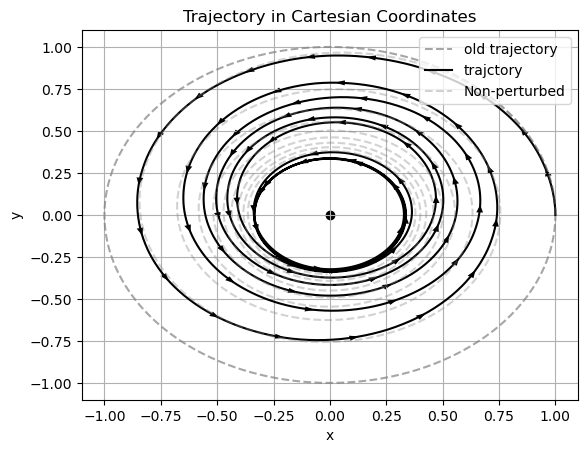

In [24]:
# plot
fig, ax = plt.subplots()
ax.plot(
    x_pos_old,
    y_pos_old,
    label="old trajectory",
    color="gray",
    linestyle="--",
    alpha=0.7,
)
ax.plot(x_pos_new, y_pos_new, label="trajctory", color="black")
plt.plot(
    x_pos_new_non_perturbed,
    y_pos_new_non_perturbed,
    label="Non-perturbed",
    color="Gray",
    linestyle="--",
    alpha=0.35,
)
ax.scatter([0], [0], color="black")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Trajectory in Cartesian Coordinates")
ax.grid(True)
ax.legend(loc=1)
ax = arrowPlot(ax, 81, x_pos_new, y_pos_new, arrowHeadSize=0.03)
plt.savefig("../Documentation/Plots/BetterComboPMPHJB")
plt.show()

We see that this combined approach achieves the desired behavior even in the presence of noise.

If we reduce the noise, the solution becomes almost identical to the original PMP path:

In [25]:
# simulate
t, x, u, r_arr, theta_arr, v_r_arr, v_t_arr = simulate_orbit(
    r1,
    GM,
    x0,
    dt=dt,
    T=T,
    K=None,
    u_max=None,
    usePMP=True,
    PMP_sol=sol,
    combination=True,
    time_vary=True,
    controller=controller,
)
x_pos_new = r_arr * np.cos(theta_arr)
y_pos_new = r_arr * np.sin(theta_arr)

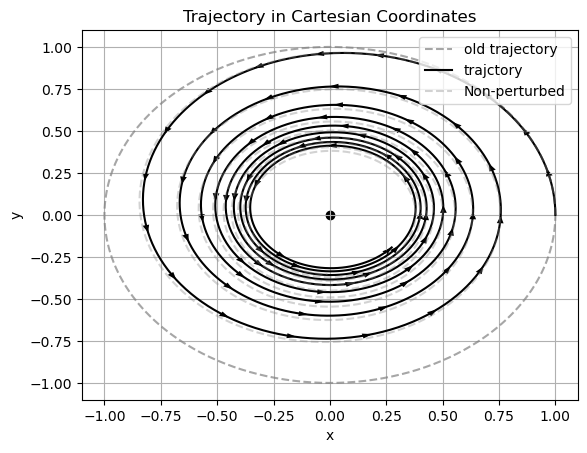

In [26]:
# plot
fig, ax = plt.subplots()
ax.plot(
    x_pos_old,
    y_pos_old,
    label="old trajectory",
    color="gray",
    linestyle="--",
    alpha=0.7,
)
ax.plot(x_pos_new, y_pos_new, label="trajctory", color="black")
plt.plot(
    x_pos_new_non_perturbed,
    y_pos_new_non_perturbed,
    label="Non-perturbed",
    color="Gray",
    linestyle="--",
    alpha=0.35,
)
ax.scatter([0], [0], color="black")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Trajectory in Cartesian Coordinates")
ax.grid(True)
ax.legend(loc=1)
ax = arrowPlot(ax, 81, x_pos_new, y_pos_new, arrowHeadSize=0.03)
plt.savefig("../Documentation/Plots/NonPerturbedComboPMPHJB")
plt.show()

This result is very close to the original PMP path without any perturbations, but now uses a time-varying K policy.